<a href="https://colab.research.google.com/github/marathomas/meerkat/blob/master/spectrograms_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background

I'll follow this tutorial: https://www.kaggle.com/deepaksinghrawat/in-depth-introduction-to-audio-for-beginners
to get a better understanding of audio files. 

Installing and importing necessary libraries:

In [ ]:
!pip install pydub

In [ ]:
import sys
from IPython.display import Audio 
import librosa
from pydub import AudioSegment
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

Mounting google drive, so that I can access the audio files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/meerkat"

 avgn_paper
'HM_VCVM001_AUDIO_file_1_(2017_08_02-06_44_59)_ASWMUX221153.wav'
'HM_VCVM001_AUDIO_file_2_(2017_08_03-06_44_59)_ASWMUX221153.wav'
'HM_VCVM001_AUDIO_file_3_(2017_08_04-06_44_59)_ASWMUX221153.wav'
'HM_VCVM001_AUDIO_file_4_(2017_08_05-06_44_59)_ASWMUX221153.wav'


In [ ]:
audio2_path = '/content/drive/My Drive/meerkat/HM_VCVM001_AUDIO_file_2_(2017_08_03-06_44_59)_ASWMUX221153.wav'

In [ ]:
audio2 = AudioSegment.from_wav(audio2_path)

Taking a minute out of that recording, so that processing is easier (session always crashed with the full file). I manually selected a section with meerkat vocalizations:

In [ ]:
audio2_short = audio2[29*60000:30*60000]

NameError: ignored

In [ ]:
%cd /content/drive/My Drive/meerkat
%mkdir chunks

/content/drive/My Drive/meerkat


In [ ]:
%cd chunks

/content/drive/My Drive/meerkat/chunks


For further ease of processing, sliced this into 10s chunks:

In [ ]:
slices = audio2_short[::10000]
counter=1
for element in slices:
  new_name = "audio2_"+str(counter)
  element.export(str(new_name+".wav"), format="wav") 
  counter+=1

audio2_1.wav  audio2_3.wav  audio2_5.wav
audio2_2.wav  audio2_4.wav  audio2_6.wav


Looking at a random chunk:

In [ ]:
y, sr = librosa.load("audio2_6.wav", sr=None)
Audio(y, rate=sr)

The signal (y) is just a numpy array with the amplitude of the wave. In our example, the audio was sampled 8000 times per second, so our data is a 1 dimensional tensor with length 8000*time in seconds = 80000 samples

In [ ]:
print("Sample rate  :", sr)
print("Signal Length:", len(y))
print("Duration     :", len(y)/sr, "seconds")

Sample rate  : 8000
Signal Length: 80000
Duration     : 10.0 seconds


Plotting the waveform (amplitude plotted over time).

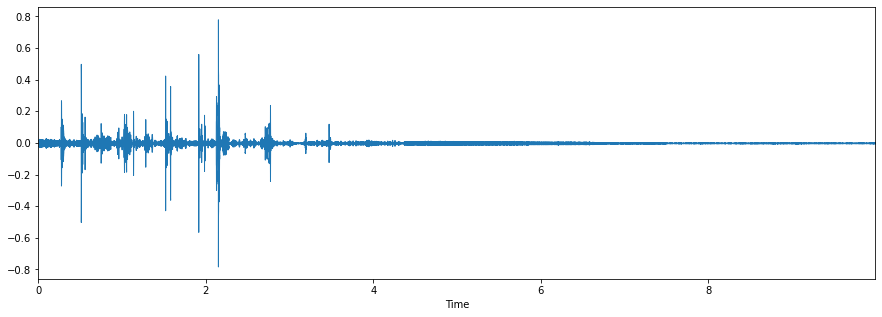

In [ ]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(y, sr=sr)

# Spectrogramming

Generate raw spectrogram from the 10s audio file using 'librosa.stft'. stft returns a complex result with a real component, the magnitude, and a complex part, the phase. We'll only use the magnitude for now and plot it as color along x-axis (time) and y-axis (frequency).

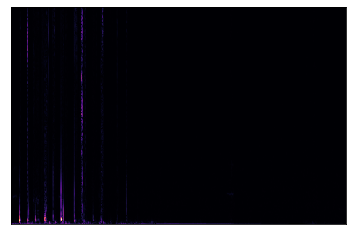

In [ ]:
sg0 = librosa.stft(y, n_fft=512)
sg_mag, sg_phase = librosa.magphase(sg0)
display(librosa.display.specshow(sg_mag))

In [ ]:
print(sg_mag.shape)

(257, 626)


Using mel scale instead of raw frequency:

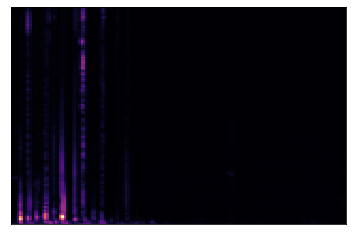

In [ ]:
sg1 = librosa.feature.melspectrogram(S=sg_mag, sr=sr)
display(librosa.display.specshow(sg1))

Additionally, using db scale instead of raw magnitude:

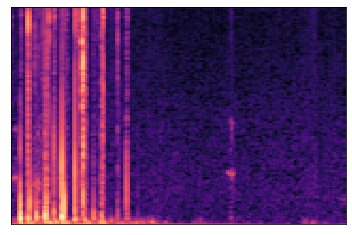

In [ ]:
sg2 = librosa.amplitude_to_db(sg1, ref=np.min)
librosa.display.specshow(sg2)

The vocalizations are hardly recognizable, the noise is quite intense and covers the whole spectrum of frequencies.
Dynamic theshold segmentation may recognize some chirps but probably also lots of noise.

In [ ]:
Audio(y, rate=sr)

Text(0.5, 1.0, 'Mel spectrogram')

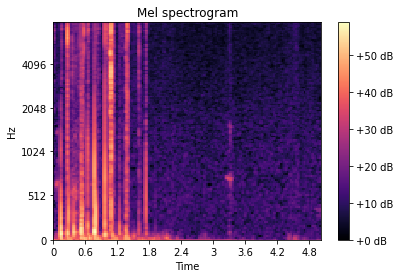

In [ ]:
librosa.display.specshow(sg2, sr=16000, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')

Why is the time only 5s?

# Decibel

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

As I'm using the maximum value of the spectrogram as reference, each power intensity pixel is expressed as the ratio of its intensity/max intensity. So, only values between 0-1 are possible for this ratio. Then, to convert it into dB, librosa function takes 10*log10(ratio). 

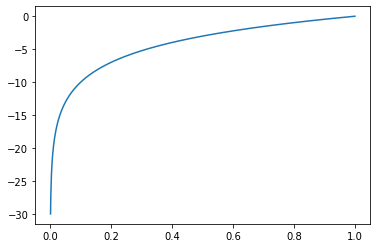

In [11]:
x = np.arange(0.001,1,0.001)
y = np.asarray([10 * math.log10(i) for i in x])
plt.plot(x,y)

So the resulting values are all negative and the resolution is better for the signals with comparatively low power. The difference between sounds that are 9/10 and 8/10 the power of the maximal value is much smaller than the difference between sounds that are 1/10 or 2/10 of the power of the max. Somehow makes sense because imagine the max value would be 100. Then the difference between 80 and 90 is ten on an absolute scale, but one sound is actually 8/9th of the other. Whereas between 10 and 20, one sound is HALF the intensity as the other.

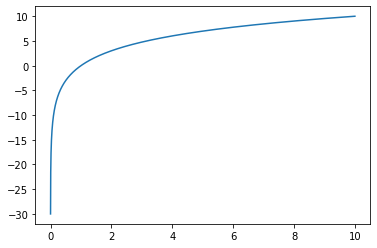

In [16]:
# If you'd put reference somewhere else, maybe median, so that also values >1 can be ratios.

x = np.arange(0.001,10,0.001)
y = np.asarray([10 * math.log10(i) for i in x])
plt.plot(x,y)

Then later, I'm taking the median per column and subtract that median, in order to have some sort of denoising. So then, all values represent difference to median dB and thus, there can be positive values again. I think, the subtraction makes sense.

Then later, I normalize the features column-wise. Meaning that, for each position of the spectrogram, I check the mean and standard deviation of all spectrograms and then use the SD from the mean for each sample. In my view, this should be the only reason why I could get different results for direct transformation of all spectrograms as opposed to transforming a bunch and then projecting new data into the space.